In [1]:
# spamFinal.ipynb - Complete Spam Detection Training
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.pipeline import Pipeline
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
RSEED = 42
np.random.seed(RSEED)

print("🔧 Loading and preprocessing data...")

🔧 Loading and preprocessing data...


In [2]:
# Load the dataset
df = pd.read_csv("spam.csv", encoding='latin-1')

# Display basic info
print("Dataset Info:")
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print("\nLabel Distribution:")
print(df['type'].value_counts())
print(f"\nSpam percentage: {(df['type'] == 'spam').mean():.2%}")

# Check for missing values
print(f"\nMissing values:\n{df.isnull().sum()}")

Dataset Info:
Shape: (84, 3)
Columns: ['title', 'text', 'type']

Label Distribution:
type
not spam    58
spam        26
Name: count, dtype: int64

Spam percentage: 30.95%

Missing values:
title    0
text     0
type     0
dtype: int64


In [3]:
# Data Preprocessing
def preprocess_text(text):
    """
    Comprehensive text preprocessing
    """
    if not isinstance(text, str):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\.\S+', ' URL ', text)
    
    # Remove email addresses
    text = re.sub(r'\S+@\S+', ' EMAIL ', text)
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', ' ', text)
    
    # Remove special characters and numbers (keep only letters)
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Combine title and text
df['full_text'] = df['title'].fillna('') + ' ' + df['text'].fillna('')
df['cleaned_text'] = df['full_text'].apply(preprocess_text)

# Remove empty texts
df = df[df['cleaned_text'].str.strip() != '']

# Convert labels to binary
df['label'] = df['type'].map({'spam': 1, 'not spam': 0})

print(f"Final dataset size: {len(df)}")
print(f"Spam: {(df['label'] == 1).sum()}, Not Spam: {(df['label'] == 0).sum()}")

Final dataset size: 84
Spam: 26, Not Spam: 58


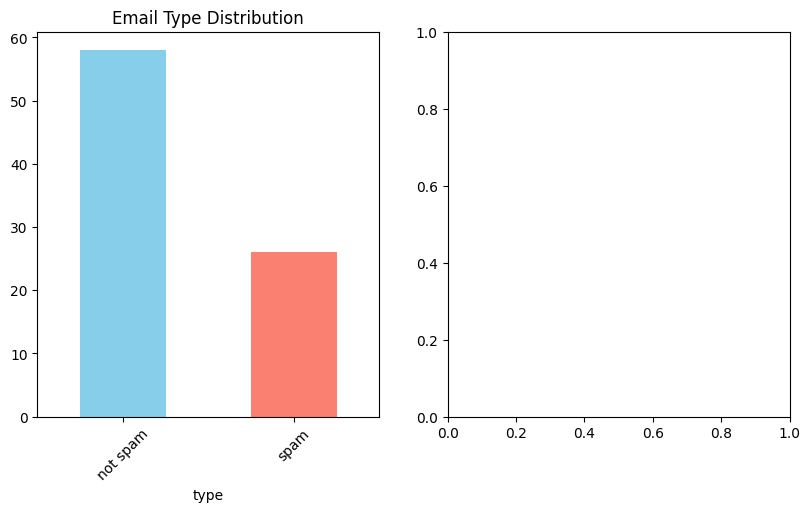

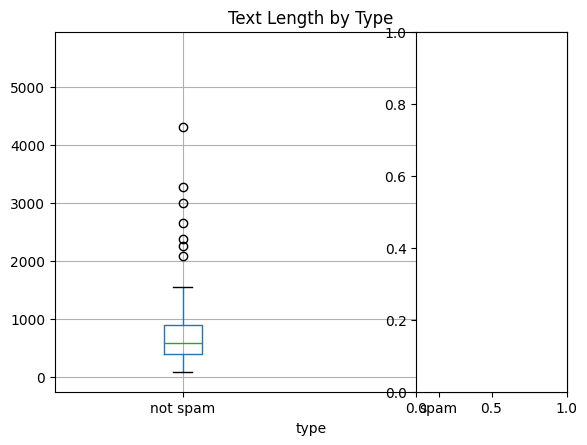

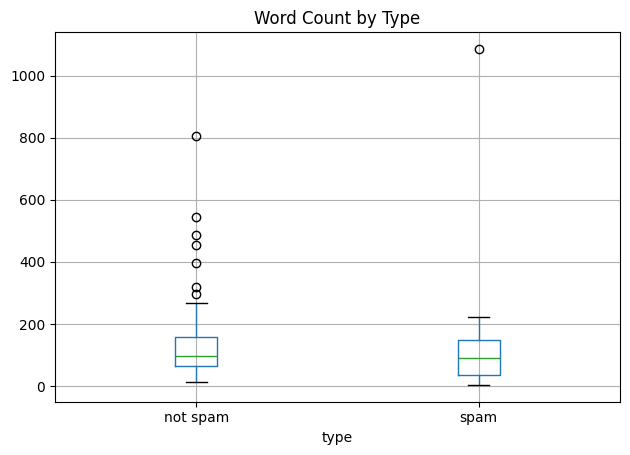


Text Statistics:
         text_length                                                       \
               count        mean          std   min     25%    50%    75%   
type                                                                        
not spam        58.0  852.896552   845.194729  79.0  386.75  583.0  902.0   
spam            26.0  718.961538  1074.109621  27.0  191.50  520.0  831.0   

                 word_count                                                    \
             max      count        mean         std   min    25%   50%    75%   
type                                                                            
not spam  4310.0       58.0  144.879310  144.700426  14.0  66.25  97.5  157.0   
spam      5664.0       26.0  132.653846  204.513265   4.0  37.25  92.0  149.0   

                  
             max  
type              
not spam   805.0  
spam      1085.0  


In [4]:
# Exploratory Data Analysis
plt.figure(figsize=(15, 5))

# Plot 1: Label distribution
plt.subplot(1, 3, 1)
df['type'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Email Type Distribution')
plt.xticks(rotation=45)

# Plot 2: Text length distribution
plt.subplot(1, 3, 2)
df['text_length'] = df['cleaned_text'].str.len()
df.boxplot(column='text_length', by='type')
plt.title('Text Length by Type')
plt.suptitle('')

# Plot 3: Word count distribution
plt.subplot(1, 3, 3)
df['word_count'] = df['cleaned_text'].str.split().str.len()
df.boxplot(column='word_count', by='type')
plt.title('Word Count by Type')
plt.suptitle('')

plt.tight_layout()
plt.show()

# Display text statistics
print("\nText Statistics:")
print(df.groupby('type')[['text_length', 'word_count']].describe())

In [5]:
# Feature Engineering and Model Training
X = df['cleaned_text']
y = df['label']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RSEED
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Training spam ratio: {y_train.mean():.2%}")
print(f"Test spam ratio: {y_test.mean():.2%}")

Training set: 67 samples
Test set: 17 samples
Training spam ratio: 31.34%
Test spam ratio: 29.41%


In [6]:
# Define different models to try
models = {
    'Logistic Regression': LogisticRegression(random_state=RSEED, max_iter=1000),
    'Multinomial NB': MultinomialNB(),
    'Random Forest': RandomForestClassifier(random_state=RSEED, n_estimators=100),
    'SVM': SVC(random_state=RSEED, probability=True)
}

# Define parameter grids for hyperparameter tuning
param_grids = {
    'Logistic Regression': {
        'tfidf__max_features': [1000, 2000, 5000],
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'clf__C': [0.1, 1, 10],
        'clf__class_weight': [None, 'balanced']
    },
    'Multinomial NB': {
        'tfidf__max_features': [1000, 2000, 5000],
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'clf__alpha': [0.1, 0.5, 1.0]
    },
    'Random Forest': {
        'tfidf__max_features': [1000, 2000],
        'clf__n_estimators': [50, 100],
        'clf__max_depth': [10, 20, None]
    },
    'SVM': {
        'tfidf__max_features': [1000, 2000],
        'clf__C': [0.1, 1, 10],
        'clf__kernel': ['linear', 'rbf']
    }
}

In [7]:
# Train and evaluate models
best_models = {}
results = []

for model_name, model in models.items():
    print(f"\n🚀 Training {model_name}...")
    
    # Create pipeline
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(stop_words='english', max_features=2000)),
        ('clf', model)
    ])
    
    # Hyperparameter tuning
    if model_name in param_grids:
        grid_search = GridSearchCV(
            pipeline, param_grids[model_name], 
            cv=5, scoring='f1', n_jobs=-1, verbose=0
        )
        grid_search.fit(X_train, y_train)
        best_models[model_name] = grid_search.best_estimator_
        best_params = grid_search.best_params_
    else:
        pipeline.fit(X_train, y_train)
        best_models[model_name] = pipeline
        best_params = "Default"
    
    # Predictions
    y_pred = best_models[model_name].predict(X_test)
    y_pred_proba = best_models[model_name].predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    # Cross-validation score
    cv_scores = cross_val_score(best_models[model_name], X_train, y_train, cv=5, scoring='f1')
    
    results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'AUC-ROC': auc,
        'CV F1 Mean': cv_scores.mean(),
        'CV F1 Std': cv_scores.std(),
        'Best Params': best_params
    })
    
    print(f"✅ {model_name} - Accuracy: {accuracy:.4f}, AUC: {auc:.4f}")

# Display results
results_df = pd.DataFrame(results)
print("\n" + "="*80)
print("📊 MODEL COMPARISON RESULTS:")
print("="*80)
print(results_df.round(4))


🚀 Training Logistic Regression...
✅ Logistic Regression - Accuracy: 0.7647, AUC: 0.9333

🚀 Training Multinomial NB...
✅ Multinomial NB - Accuracy: 0.8235, AUC: 0.9000

🚀 Training Random Forest...
✅ Random Forest - Accuracy: 0.6471, AUC: 0.6333

🚀 Training SVM...
✅ SVM - Accuracy: 0.8824, AUC: 0.9000

📊 MODEL COMPARISON RESULTS:
                 Model  Accuracy  AUC-ROC  CV F1 Mean  CV F1 Std  \
0  Logistic Regression    0.7647   0.9333      0.5667     0.2858   
1       Multinomial NB    0.8235   0.9000      0.6324     0.1487   
2        Random Forest    0.6471   0.6333      0.1600     0.1960   
3                  SVM    0.8824   0.9000      0.4776     0.2657   

                                         Best Params  
0  {'clf__C': 0.1, 'clf__class_weight': 'balanced...  
1  {'clf__alpha': 0.1, 'tfidf__max_features': 200...  
2  {'clf__max_depth': 10, 'clf__n_estimators': 50...  
3  {'clf__C': 10, 'clf__kernel': 'linear', 'tfidf...  


In [8]:
# Select the best model based on AUC-ROC
best_model_name = results_df.loc[results_df['AUC-ROC'].idxmax(), 'Model']
best_model = best_models[best_model_name]

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"Best Parameters: {results_df.loc[results_df['AUC-ROC'].idxmax(), 'Best Params']}")

# Detailed evaluation of the best model
y_pred_best = best_model.predict(X_test)
y_pred_proba_best = best_model.predict_proba(X_test)[:, 1]

print("\n📈 BEST MODEL DETAILED PERFORMANCE:")
print("="*50)
print(f"Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba_best):.4f}")
print(f"Cross-val F1: {results_df.loc[results_df['AUC-ROC'].idxmax(), 'CV F1 Mean']:.4f}")

print("\n📋 CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_best, target_names=['Not Spam', 'Spam']))


🏆 BEST MODEL: Logistic Regression
Best Parameters: {'clf__C': 0.1, 'clf__class_weight': 'balanced', 'tfidf__max_features': 1000, 'tfidf__ngram_range': (1, 2)}

📈 BEST MODEL DETAILED PERFORMANCE:
Accuracy: 0.7647
AUC-ROC: 0.9333
Cross-val F1: 0.5667

📋 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

    Not Spam       0.79      0.92      0.85        12
        Spam       0.67      0.40      0.50         5

    accuracy                           0.76        17
   macro avg       0.73      0.66      0.67        17
weighted avg       0.75      0.76      0.74        17



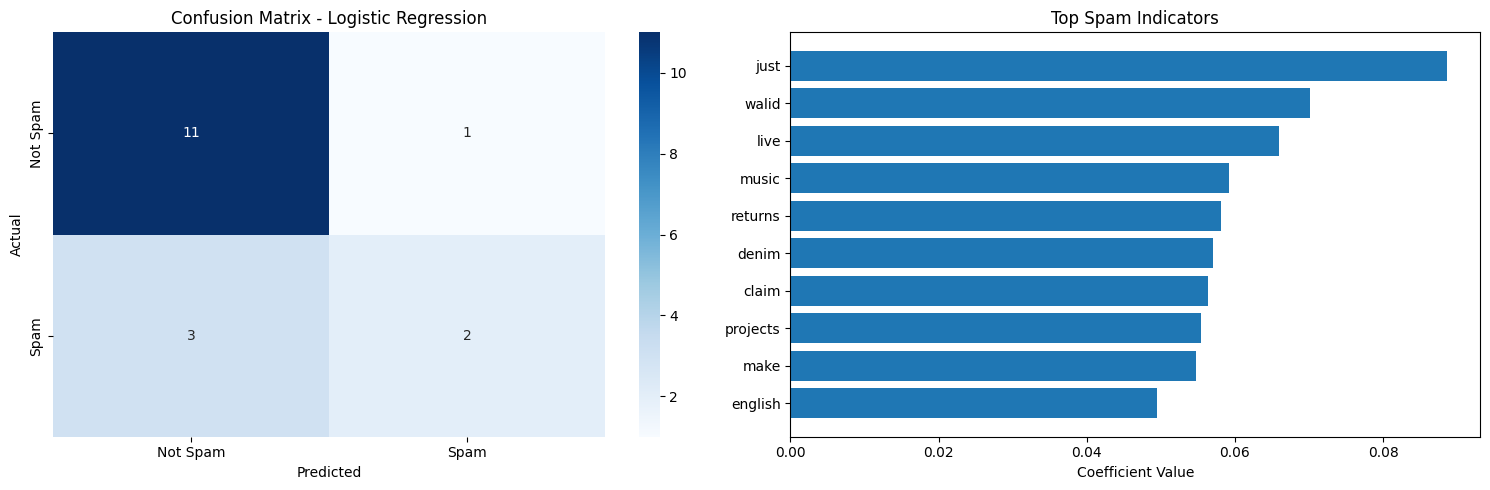

In [9]:
# Confusion Matrix Visualization
plt.figure(figsize=(15, 5))

# Confusion Matrix
plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Spam', 'Spam'], 
            yticklabels=['Not Spam', 'Spam'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Feature Importance (for interpretable models)
plt.subplot(1, 2, 2)
if hasattr(best_model.named_steps['clf'], 'coef_'):
    feature_names = best_model.named_steps['tfidf'].get_feature_names_out()
    coefficients = best_model.named_steps['clf'].coef_[0]
    
    # Get top 10 spam indicators
    top_spam_idx = np.argsort(coefficients)[-10:]
    top_spam_words = [feature_names[i] for i in top_spam_idx]
    top_spam_scores = coefficients[top_spam_idx]
    
    # Get top 10 ham indicators
    top_ham_idx = np.argsort(coefficients)[:10]
    top_ham_words = [feature_names[i] for i in top_ham_idx]
    top_ham_scores = coefficients[top_ham_idx]
    
    # Plot top spam words
    plt.barh(range(len(top_spam_words)), top_spam_scores)
    plt.yticks(range(len(top_spam_words)), top_spam_words)
    plt.title('Top Spam Indicators')
    plt.xlabel('Coefficient Value')

plt.tight_layout()
plt.show()

In [10]:
# Model Interpretation Function
def explain_prediction(model, text, top_n=10):
    """
    Explain why a text was classified as spam or not spam
    """
    if hasattr(model.named_steps['clf'], 'coef_'):
        # For linear models
        vectorizer = model.named_steps['tfidf']
        classifier = model.named_steps['clf']
        
        # Transform the text
        X_vec = vectorizer.transform([text])
        feature_names = vectorizer.get_feature_names_out()
        
        # Get coefficients and feature values
        coefficients = classifier.coef_[0]
        feature_values = X_vec.toarray()[0]
        
        # Calculate contribution of each feature
        contributions = coefficients * feature_values
        
        # Get indices of non-zero features
        non_zero_idx = np.where(feature_values != 0)[0]
        
        if len(non_zero_idx) > 0:
            # Sort by absolute contribution
            sorted_idx = non_zero_idx[np.argsort(np.abs(contributions[non_zero_idx]))[::-1]]
            
            print("🔍 PREDICTION EXPLANATION:")
            print("Top contributing features:")
            for i, idx in enumerate(sorted_idx[:top_n]):
                word = feature_names[idx]
                contribution = contributions[idx]
                direction = "↑ SPAM" if contribution > 0 else "↓ NOT SPAM"
                print(f"  {word}: {contribution:.4f} ({direction})")
            
            return contributions
    return None

# Test explanation on sample texts
test_texts = [
    "Congratulations! You've won a $1000 prize. Click here to claim.",
    "Hi John, let's meet for lunch tomorrow at 12 PM.",
    "URGENT: Your account will be suspended. Verify now!",
    "Meeting reminder: Team sync at 3 PM in conference room B."
]

print("\n🧪 TESTING MODEL EXPLANATIONS:")
print("="*60)
for i, text in enumerate(test_texts, 1):
    cleaned_text = preprocess_text(text)
    prediction = best_model.predict([cleaned_text])[0]
    probability = best_model.predict_proba([cleaned_text])[0][1]
    
    print(f"\nTest {i}:")
    print(f"Text: {text}")
    print(f"Prediction: {'SPAM' if prediction == 1 else 'NOT SPAM'}")
    print(f"Spam Probability: {probability:.4f}")
    explain_prediction(best_model, cleaned_text)
    print("-" * 40)


🧪 TESTING MODEL EXPLANATIONS:

Test 1:
Text: Congratulations! You've won a $1000 prize. Click here to claim.
Prediction: SPAM
Spam Probability: 0.5085
🔍 PREDICTION EXPLANATION:
Top contributing features:
  claim: 0.0350 (↑ SPAM)
  ve: 0.0125 (↑ SPAM)
  click: 0.0103 (↑ SPAM)
  won: 0.0002 (↑ SPAM)
----------------------------------------

Test 2:
Text: Hi John, let's meet for lunch tomorrow at 12 PM.
Prediction: NOT SPAM
Spam Probability: 0.4959
🔍 PREDICTION EXPLANATION:
Top contributing features:
  hi: 0.0104 (↑ SPAM)
  meet: 0.0082 (↑ SPAM)
  john: -0.0060 (↓ NOT SPAM)
  let: -0.0030 (↓ NOT SPAM)
  pm: -0.0019 (↓ NOT SPAM)
----------------------------------------

Test 3:
Text: URGENT: Your account will be suspended. Verify now!
Prediction: NOT SPAM
Spam Probability: 0.4837
🔍 PREDICTION EXPLANATION:
Top contributing features:
  account: -0.0223 (↓ NOT SPAM)
  verify: -0.0190 (↓ NOT SPAM)
----------------------------------------

Test 4:
Text: Meeting reminder: Team sync at 3 PM in c

In [11]:
# Save the best model
model_filename = "spam_classifier_pipeline.joblib"
joblib.dump(best_model, model_filename)

# Also save the preprocessing function separately
preprocessing_artifacts = {
    'preprocess_function': preprocess_text,
    'feature_names': best_model.named_steps['tfidf'].get_feature_names_out() if hasattr(best_model.named_steps['tfidf'], 'get_feature_names_out') else None,
    'model_info': {
        'model_name': best_model_name,
        'accuracy': accuracy_score(y_test, y_pred_best),
        'auc_roc': roc_auc_score(y_test, y_pred_proba_best),
        'training_date': pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S")
    }
}

joblib.dump(preprocessing_artifacts, "preprocessing_artifacts.joblib")

print(f"\n💾 MODEL SAVED SUCCESSFULLY!")
print(f"Main model: {model_filename}")
print(f"Preprocessing artifacts: preprocessing_artifacts.joblib")
print(f"\n📊 FINAL MODEL PERFORMANCE SUMMARY:")
print(f"Best Model: {best_model_name}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
print(f"Test AUC-ROC: {roc_auc_score(y_test, y_pred_proba_best):.4f}")
print(f"Model saved for deployment! 🚀")


💾 MODEL SAVED SUCCESSFULLY!
Main model: spam_classifier_pipeline.joblib
Preprocessing artifacts: preprocessing_artifacts.joblib

📊 FINAL MODEL PERFORMANCE SUMMARY:
Best Model: Logistic Regression
Test Accuracy: 0.7647
Test AUC-ROC: 0.9333
Model saved for deployment! 🚀
